In [2]:
%load_ext autoreload
%autoreload 2

In [105]:
import transformers
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, AdamW, BertForTokenClassification,\
    BertTokenizer, LayoutLMTokenizer, AutoTokenizer, AutoModelForMaskedLM, pipeline, DataCollatorForLanguageModeling
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy
import seaborn as sns
import pandas as pd

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.trainer import BertTrainer, LayoutLMTrainer
import warnings
warnings.filterwarnings("ignore")

## Importing dataset

In [4]:
dataset = load_dataset("nielsr/funsd")

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [6]:
!mkdir logs
model_name = "PET"
dataset_name = "FUNSD"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

In [21]:
class PatternExploitingDataset(Dataset):
    def __init__(self, 
                 data,
                 tokenizer,
                 pattern : callable,
                 num_samples : int = 10) -> None:
        super().__init__()
        
        self.label_names = data\
            .features['ner_tags']\
            .feature\
            .names
        self.label_keymap = {k:v for k,v in enumerate(self.label_names)} 

        self.pattern = pattern
        self.tokenizer = tokenizer

        self.num_samples = num_samples
        self._ignore(data[0:num_samples])

    
    def _ignore(
        self, 
        data,
        should_ignore = [";", ":", ".", " ", ""]
    ):
        
        self.words = []
        self.labels = []
        for i in range(self.num_samples):
            words = data['words'][i]
            labels = data['ner_tags'][i]

            this_words = []
            this_labels = []

            for j in range(len(words)):

                if not words[j] in should_ignore:
                    this_words.append(words[j])
                    this_labels.append(labels[j])

            self.words.append(this_words)
            self.labels.append(this_labels)
    
    def __getitem__(self, document_index : int):
        phrases = []
        targets = []


        words = self.words[document_index]
        labels = self.labels[document_index]

        for idx, word in enumerate(words):
            label_idx = labels[idx]
            label_name = self.label_keymap[label_idx]

            phrase = self.pattern(word, tokenizer)
            phrases.append(phrase)
            
            if label_name == "O":
                targets.append("NONE") 
            else :
                targets.append(label_name[2:])

        return phrases, targets
    
    def __len__(self):
        return len(self.words)
                

In [22]:
def pattern1(word : str,
            tokenizer):
    return f" In a document, where is the word {word} most frequently encountered, be it in the header, a question, or an answer? {tokenizer.mask_token}"

In [23]:
data = PatternExploitingDataset(
    dataset['train'],
    tokenizer,
    pattern1,
    num_samples = 10
)

In [26]:
labels_idx_keymap = {
    "none": 0,
    "question" : 1,
    "answer": 2,
    "header" : 3,
}

In [81]:
device = "cuda"
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased")
model.to(device)

DistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.

In [86]:
device = "cuda"


model.train()

alpha = 0
n_epochs = 10

optmizer = AdamW(model.parameters(), 1e-5)
history = []

for epoch in range(n_epochs):
    y_true_train = torch.tensor([],device=device)
    y_pred_train = torch.tensor([],device=device)

    for i in tqdm(range(len(data))):

        phrases, labels = data[i]

        for idx, phrase in (enumerate(phrases)):
            tokens = tokenizer(
                phrases,
                truncation= True,
                padding= "max_length",
                return_tensors= "pt",
                max_length=32
            )

            correct_word = tokenizer.tokenize(labels[idx])[0]

            label = tokenizer(
                correct_word,
            )

            input_ids = tokens['input_ids'].to(device)
            attention_mask = tokens['attention_mask'].to(device)

            y = input_ids.clone()


            y[input_ids== tokenizer.mask_token_id] = tokenizer.vocab[correct_word]
            y[input_ids != tokenizer.mask_token_id] = -100

            outputs = model(
                input_ids =input_ids,
                attention_mask = attention_mask,
                labels = y
            )

            mask_token_index = torch.where(tokens["input_ids"] == tokenizer.mask_token_id)[1]
            mask_token_logits = outputs.logits[0, mask_token_index, :]

            question_logits = mask_token_logits[0,tokenizer.vocab["question"]].item()
            answer_logits = mask_token_logits[0, tokenizer.vocab["answer"]].item()
            header_logits = mask_token_logits[0, tokenizer.vocab["header"]].item()
            none_logits = mask_token_logits[0, tokenizer.vocab["none"]].item()



            logits_list = torch.tensor([
                none_logits,
                question_logits, 
                answer_logits,
                header_logits
            ])

            real_value = correct_word.lower()
            real_value = labels_idx_keymap[real_value]

            predicted_value = logits_list.argmax().item()

            y_pred_train = torch.cat([
                y_pred_train, 
                torch.tensor([predicted_value]).to(device)
            ])
            
            y_true_train = torch.cat([
                y_true_train,
                torch.tensor([real_value]).to(device)
            ])

            real_list = [0,0,0,0]
            real_list[real_value] =1

            real_list = torch.tensor(
                real_list
            )

            ce_loss = cross_entropy(
                logits_list.softmax(dim = 0).to(torch.float64),
                real_list.to(torch.float64)
            )



            mlm_loss = outputs.loss
            loss = (1-alpha)*ce_loss + mlm_loss*alpha

            loss.backward()

            optmizer.step()
            optmizer.zero_grad()

    f1 = multiclass_f1_score(
        y_pred_train,
        y_true_train,
        num_classes=4
    )
    history.append(f1)

    logging.info(f'''
                 
    -------------------------
        End of epoch {epoch} 
        F1 score : {f1}     
    ''')

    logging.info(f'''
        {multiclass_confusion_matrix(
        y_pred_train.to(torch.int64),
        y_true_train.to(torch.int64),
        num_classes=4
        )}
    ''')

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [02:21<05:31, 47.33s/it]


KeyboardInterrupt: 

In [69]:
ce_loss = cross_entropy(
    logits_list.to(torch.float64),
    predicted_list.to(torch.float64)
)

In [70]:
ce_loss

tensor(1.5447, dtype=torch.float64)

In [71]:
loss = (1-alpha) * ce_loss + alpha*mlm_loss

In [72]:
labels_idx_keymap = {
    "none": 0,
    "question" : 1,
    "answer": 2,
    "header" : 3,
}

In [87]:
validation_dataset = PatternExploitingDataset(
    dataset['test'],
    tokenizer,
    pattern1,
    num_samples=30
)

In [88]:
y_true_train = torch.tensor([],device=device)
y_pred_train = torch.tensor([],device=device)

with torch.no_grad():
    for i in tqdm(range(len(validation_dataset))):

        phrases, labels = validation_dataset[i]

        for idx, phrase in (enumerate(phrases)):
            tokens = tokenizer(
                phrases,
                truncation= True,
                padding= "max_length",
                return_tensors= "pt",
                max_length=32
            )

            correct_word = tokenizer.tokenize(labels[idx])[0]

            label = tokenizer(
                correct_word,
            )

            input_ids = tokens['input_ids'].to(device)
            attention_mask = tokens['attention_mask'].to(device)

            y = input_ids.clone()

            y[input_ids== tokenizer.mask_token_id] = tokenizer.vocab[correct_word]
            y[input_ids!= tokenizer.mask_token_id] = -100

            outputs = model(
                input_ids =input_ids,
                attention_mask = attention_mask,
            )

            mask_token_index = torch.where(tokens["input_ids"] == tokenizer.mask_token_id)[1]
            mask_token_logits = outputs.logits[0, mask_token_index, :]

            question_logits = mask_token_logits[0,tokenizer.vocab["question"]].item()
            answer_logits = mask_token_logits[0, tokenizer.vocab["answer"]].item()
            header_logits = mask_token_logits[0, tokenizer.vocab["header"]].item()
            none_logits = mask_token_logits[0, tokenizer.vocab["none"]].item()

            logits = {
                "question": question_logits,
                "answer": answer_logits,
                "header": header_logits,
                "none": none_logits
            }

            predicted_value = sorted(
                logits.items(), 
                reverse= True, 
                key = lambda x: x[1]
            )[0][0]

            predicted_value = labels_idx_keymap[predicted_value]

            logging.info(predicted_value)

            real_value = correct_word.lower()
            real_value = labels_idx_keymap[real_value]

            y_pred_train = torch.cat([
                y_pred_train, 
                torch.tensor([predicted_value]).to(device)
            ])
            
            y_true_train = torch.cat([
                y_true_train,
                torch.tensor([real_value]).to(device)
            ])

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [06:50<00:00, 13.69s/it]


In [62]:
correct_word

'none'

In [75]:
logits

{'question': 3.0634965896606445,
 'answer': 2.415207624435425,
 'header': 2.9105570316314697,
 'none': 1.0707943439483643}

In [89]:
predicted_value

1

In [90]:
multiclass_f1_score(
    y_pred_train.to(torch.int64),
    y_true_train.to(torch.int64),
    num_classes=4
)

tensor(0.2324, device='cuda:0')

In [96]:
conf_matrix = multiclass_confusion_matrix(
    y_pred_train.to(torch.int64),
    y_true_train.to(torch.int64),
    num_classes=4
)

In [107]:
confusion_df = pd.DataFrame(conf_matrix.cpu().numpy())

{'none': 0, 'question': 1, 'answer': 2, 'header': 3}

In [110]:
{v:k for k, v in labels_idx_keymap.items()}

{0: 'none', 1: 'question', 2: 'answer', 3: 'header'}

In [115]:
confusion_df = confusion_df\
    .rename(columns={v:k for k, v in labels_idx_keymap.items()})\
    .rename(index = {v:k for k, v in labels_idx_keymap.items()})

Text(0.5, 1.0, '\n    Confusion matrix\n    Pattern Exploited Training    \n')

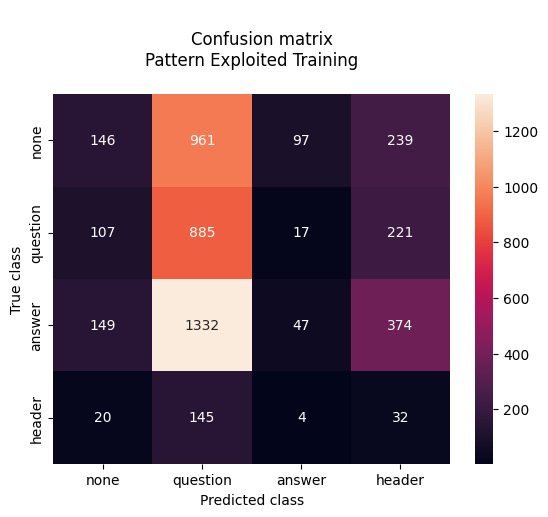

In [125]:
sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title('''
    Confusion matrix
    Pattern Exploited Training    
''')

## Importing model

In [101]:
dataset['train'][0].keys()

dict_keys(['id', 'words', 'bboxes', 'ner_tags', 'image_path'])

In [102]:
text = " ".join(dataset['train'][0]['words'])

In [103]:
masked_text = dataset['train'][0]['words']

In [150]:
p1 = lambda s, label: s +" is the <mask> of a " + label + " token"

In [151]:
label_names = dataset['train'].features['ner_tags'].feature.names
keymap = {i : v for i, v in enumerate(label_names)}

In [152]:
keymap

{0: 'O',
 1: 'B-HEADER',
 2: 'I-HEADER',
 3: 'B-QUESTION',
 4: 'I-QUESTION',
 5: 'B-ANSWER',
 6: 'I-ANSWER'}

In [153]:
keymap = {
    0:"None",
    1: "header",
    2: "header",
    3: "question",
    4: "question",
    5: "answer",
    6: "answer"
}

In [154]:
sentences = []
targets = []
for i in range(len(dataset['train'][0]['words'])):
    word_i = dataset['train'][0]['words'][i]
    label_i = keymap[dataset['train'][0]['ner_tags'][i]]
    targets.append(dataset['train'][0]['ner_tags'][i])
    sentences.append(p1(word_i, label_i))

In [155]:
outputs = mlm(sentences, targets = ["begin", "middle", "outside"])

In [149]:
outputs[9]

[{'score': 7.035053872783692e-09,
  'token': 35301,
  'token_str': 'outside',
  'sequence': 'Is QUALITY theoutside of a header token'},
 {'score': 9.60384105574974e-10,
  'token': 43230,
  'token_str': 'begin',
  'sequence': 'Is QUALITY thebegin of a header token'},
 {'score': 5.127795965620408e-10,
  'token': 29917,
  'token_str': 'middle',
  'sequence': 'Is QUALITY themiddle of a header token'}]

In [148]:
targets[9]

'header'